# Problem Set 2

This problem set will give you the opportunity to download and analyze a small corpus of mobile phone metadata, in order to study the internal migration response to a major earthquake.  The problem set relates loosely to several papers discussed in the class, and in particular to <a href='http://www.sciencedirect.com/science/article/pii/S0304387816000109'>"Airtime Transfers and Mobile Communications: Evidence in the Aftermath of Natural Disasters"</a>. You might wish to familiarize yourself with this paper before beginning the assignment.

![title](datasets/heatmap.png)

## Overview of the problem set

These are the key steps in the problem set:

1. Download the CDR and familiarize yourself with the dataset
2. Develop a method for detecting a "migration" event
3. Analyze the migration response to the Lake Kivu earthquake

# 1. Conduct exploratory analysis of the Call Detail Records

Download the three datasets from the course website (available on bCourses under files/PS2).
- `cdr_sample.zip`: This dataset contains the full Call Detail Records of a few thousand individuals. These data have been pseudonymized and partially fabricated, to ensure the privacy and confidentiality of the subscribers. However, the data are not that different from the raw data that are collected by mobile phone operators throughout the world. 
    - There are six columns in this dataset: user_1 (ID of person placing call), user_2 (ID of person receiving call), date, time, tower_1 (location of user_1), and tower_2 (location of user_2). We have strategically sampled ~3600 users and their full call detail records. The users in the column user_1 are these 3600 users.
    - Note that the column user_2 might also contain those ~3600 users. Therefore, when calculating the number of logged events per person, don't forget the column user_2. 
- `celltower_location.csv`: This dataset contains the geocordinates of each cell tower, along with the district in which it is located. We added some jitter to the original coordinates, but each tower still belongs to its original district. 
- `District_Boundary_2012_merge_kigali.zip`: This dataset is the district [shapefile](https://en.wikipedia.org/wiki/Shapefile) of Rwanda. There are 30 districts in Rwanda, but we have merged the 3 districts that comprise the capital of Kigali. Thus, you will find 28 districts in the dataset.

## 1.1 Present basic descriptive statistics, tables, and figures, to summarize the data

Construct a set of tables and figures that summarize key characteristics of this dataset: how many unique individuals, what time period is covered, how many events are logged per person, and so forth. Imagine that you are constructing the first tables and figures in a research paper, and you wish to provide your reader with as much intuition as possible about what information is contained in your dataset. Be creative, but be disciplined. Your figures should be professional, carefully labelled, and easily interpreted.


In [2]:
#
# enter code here
#
import pandas as pd 
cdr_data = pd.read_csv("datasets/cdr_sample.csv") 
cdr_data.head()

,user_1,user_2,date,time,tower_1,tower_2
0,L55737047,L02196776,80617,18:30:17,9,9
1,L55737047,L45332350,80730,21:33:08,47,47
2,L55737047,L87926818,80422,14:25:31,74,74
3,L55737047,L87926818,80408,15:23:13,20,46
4,L55737047,L87926818,80123,17:35:49,171,171


In [3]:
# Uniques across each column
cdr_data.nunique()

user_1       3610
user_2     185497
date          366
time        85810
tower_1       170
tower_2       170
dtype: int64

In [4]:
user_columns = pd.concat([cdr_data.user_1, cdr_data.user_2], axis=0, sort=False)
# number of unique users (either in user_1 or user_2 columns)
user_columns.nunique()

185987

In [5]:
# date period covered
cdr_data.date.min()

70801

In [6]:
cdr_data.date.max()

80731

In [7]:
# convert dates
# cdr_date/86400+DATE(1970,1,1)
from datetime import date
from datetime import datetime
start_date = datetime(1970, 1, 1, 0, 0)



In [19]:
# number of logged events per person
# for user 1
user_1_counts = cdr_data['user_1'].value_counts()
print("Total calls " + str(cdr_data['user_1'].shape[0]))
print("Sum of calls by user_1 is " + str(user_1_counts.sum()))
user_1_counts.head()

# for user 2
user_2_counts = cdr_data['user_2'].value_counts()
print("Total calls " + str(cdr_data['user_2'].shape[0]))
print("Sum of calls by user_2 is " + str(user_2_counts.sum()))
user_2_counts.head()

Total calls 4388305
Sum of calls by user_1 is 4388305
Total calls 4388305
Sum of calls by user_2 is 4388305


L87716080    4963
L66519191    3961
L70370484    3356
L37678060    2394
L96597103    2355
Name: user_2, dtype: int64

Lowest number of calls is 1 and highest is 15


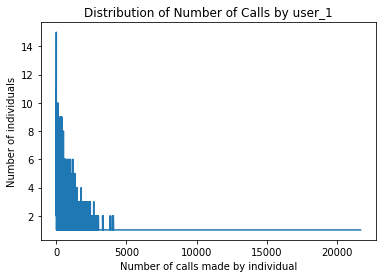

In [68]:
user_1_call_dist = user_1_counts.value_counts().sort_index()
pl = user_1_call_dist.plot()
pl.set_title("Distribution of Number of Calls by user_1")
pl.set_xlabel("Number of calls made by individual")
pl.set_ylabel("Number of individuals")
print("Lowest number of calls is " + str(user_1_call_dist.min()) + " and highest is " + str(user_1_call_dist.max()))

In [82]:
min_call = user_1_call_dist.index.min() # lowest number of calls
num_people = user_1_call_dist[min_call] # number of people with lowest number of calls
print("Lowest number of calls is " + str(min_call) + " with " + str(num_people) + " people")
max_call = user_1_call_dist.index.max() # highest number of calls
num_people = user_1_call_dist[max_call] # number of people with highest number of calls
print("Highest number of calls is " + str(max_call) + " with " + str(num_people) + " people")


Lowest number of calls is 1 with 7 people
Highest number of calls is 21644 with 1 people


In [101]:
import statistics 
statistics.mean(user_1_call_dist.index.tolist())
max(user_1_call_dist.index.tolist())
# user_1_call_dist[int(statistics.mean(user_1_call_dist.index.tolist()))-1]

21644

Text(0, 0.5, 'Number of individuals')

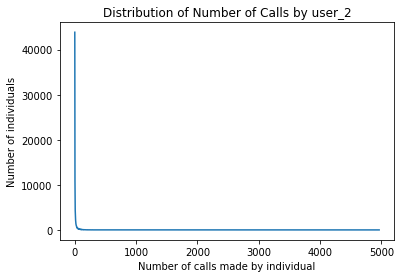

In [70]:
pl = user_2_counts.value_counts().sort_index().plot()
pl.set_title("Distribution of Number of Calls by user_2")
pl.set_xlabel("Number of calls made by individual")
pl.set_ylabel("Number of individuals")

Lowest number of calls is 1 and highest is 21644


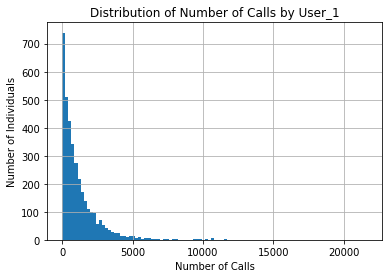

In [31]:
hist_user1 = user_1_counts.hist(bins=100)
hist_user1.set_title('Distribution of Number of Calls by User_1')
hist_user1.set_xlabel("Number of Calls")
hist_user1.set_ylabel("Number of Individuals")
print("Lowest number of calls is " + str(user_1_counts.min()) + " and highest is " + str(user_1_counts.max()))


In [42]:
len(user_2_counts[user_2_counts==1])

43861

Lowest number of calls is 1 and highest is 4963


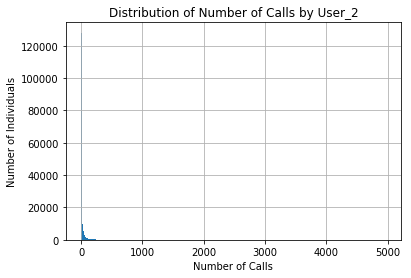

In [51]:

hist_user2 = user_2_counts.hist(bins=500)
hist_user2.set_title('Distribution of Number of Calls by User_2')
hist_user2.set_xlabel("Number of Calls")
hist_user2.set_ylabel("Number of Individuals")
print("Lowest number of calls is " + str(user_2_counts.min()) + " and highest is " + str(user_2_counts.max()))

4388305

In [ ]:
# for user 2



In [ ]:
# distribution of logged events over time

# by person

# by location

In [ ]:
# distribution of times
cdr_data['time'].value_counts()[:20].plot()

In [ ]:
#distribution of dates

In [6]:
# cell tower data
celltower_data = pd.read_csv("datasets/celltower_location.csv")
celltower_data.head()

,antenna_id,longitude,latitude,district
0,1,30.096104,-1.931660,Kigali
1,3,30.122176,-1.997260,Kigali
2,4,30.070381,-1.951818,Kigali
3,5,30.062391,-1.918881,Kigali
4,6,30.159390,-2.017144,Kigali


In [7]:
# number of unique celltowers
celltower_data.nunique()

antenna_id    267
longitude     267
latitude      267
district       28
dtype: int64

## 1.2 Show off your mapping skills

Construct a figure (or two) that provides some geo-spatial intuition behind these data. The `celltower_locations.csv` file will allow you to map towers (referenced in the CDR) to GPS coordinates. Some ideas for what you might do:
 - Construct a heat-map showing the density of frequently visited locations
 - Show a voronoi tesselation of the country, to give an intuition for the density of towers in different locations
 - Assign a 'home location' to each person (up to you how to do so!), and map each person's home location
 - Build a time-series to visualize how the spatial distribution of phone use changes over time
 - Something else creative that you come up with!

Hint: You might considering using [geopandas](http://geopandas.org/) to read shapefile, [shapely](https://github.com/Toblerity/Shapely) to create geometry, and [folium](https://python-visualization.github.io/folium/) to create maps.

In [1]:
#
# Your code here
#

# 2. Measuring Migration

## 2.1 Write an (unsupervised) algorithm to infer migration from the CDR

For each individual in the dataset, the CDR provides you with an intermittent stream of their approximate locations over time. What I would like you to do is to convert this streaming log data into a structured dataset that makes it possible to quantify and study internal migration in Rwanda. In particular, use the data you have to quantify the number of migration events that occur in each month that is contained in the CDR. Produce a single time-series figure that has "Year-Month" on the x-axis, and "Number of observed migrations" on the y-axis.

Please note that this is actually a complex task and there are many possible ways to do this. There is no "right" way to do this -- although there are many "wrong" ways. Be creative, but be rigorous. Document and justify the decisions you make along the way, and write a few paragraphs below to summarize your approach and findings.

As a starting point, you should probably review the approach I described in <a href='http://www.tandfonline.com/doi/abs/10.1080/02681102.2011.643209'>"Inferring Patterns of Internal Migration from Mobile Phone Call Records: Evidence from Rwanda"</a>. As discussed in class, that approach has many flaws, so I strongly encourage you to come up with your own approach.

In [ ]:
#
# Your code here
#


*Your documentation, justification, interpreation goes here*



# 3. The Lake Kivu Earthquake

On February 3, 2008, a large earthquake struck the Lake Kivu region of Rwanda and the DRC (see <a href='https://en.wikipedia.org/wiki/2008_Lake_Kivu_earthquake'>wikipedia</a> and <a href='https://earthquake.usgs.gov/earthquakes/eventpage/usp000fy21/executive'>USGS</a> summaries). 

## 3.1 Did the earthquake cause internal displacement?

Use the data at your disposal to study if and how the earthquake affected the mobility and migration decisions of Rwandans. Some questions of interest (answer as many as you can!):
 - Was there an abnormal increase in the number of out-migrations from the affected region?
 - Where did the out-migrants go to?
 - How long did they stay away?

You might want to reference papers such as <a href='http://www.pnas.org/content/109/29/11576.abstract'>"Predictability of Population Displacement after the 2010 Haiti"</a> and  <a href='http://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1001083'>"Improved Response to Disasters and Outbreaks by Tracking Population Movements with Mobile Phone Network Data: A Post-Earthquake Geospatial Study in Haiti"</a>, but again keep in mind that those are early papers that should be read critically, rather than taken as gospel.

## 3.2 How else did the earthquake impact people (as observed in the phone data)?

The earthquake affected much more than the migration decisions of people near the epicenter. Do you observe any other noteworthy changes in human/social behavior following the earthquake? Document any quantitative patterns you observe in the CDR, speculate as to what might really be happening in the lives of the phone users generating the CDR, and discuss what next steps you could take if you wanted to investigate these patterns in greater detail.

A few papers that you might skim as you work on this include <a href='http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0017680'>"Collective Response of Human Populations to Large-Scale Emergencies"</a>, <a href='http://www.aaai.org/ocs/index.php/SSS/SSS10/paper/viewFile/1180/1350'>"People, Quakes, and Communications: Inferences from Call Dynamics about a Seismic Event and its Influences on a Population"</a>, and <a href='http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0120449'>"Spatiotemporal detection of unusual human population behavior using mobile phone data"</a>.

In [ ]:
#
# Your code here
#


*Your documentation, justification, interpreation goes here*
